In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from comparers import ModelComparer
from diro2c_wrapper import WrappedDiro2C, train_surrogate_tree, plot_surrogate_tree,\
                           extract_rules, print_rules, evaluate_generated_data,\
                           evaluate, plot_tree_leafs_2d, plot_diro2c_2d, get_surrogate_tree,\
                           get_feature_importances, plot_feature_importances, search_max_depth_parameter
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity
from tasks.boston_housing import make_task3 as make_task

In [2]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Explanations

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

In [5]:
global_fidelities = {}
local_fidelities = {}
complexities = {}

## $(0,1)$

In [6]:
focus_class = '(0, 1)'
focus_class_idx = list(comparer.class_names).index(focus_class)
y_true = mclass_diff == focus_class_idx

In [22]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 13min 36s, sys: 13.4 s, total: 13min 49s
Wall time: 18min 34s


In [7]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [8]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

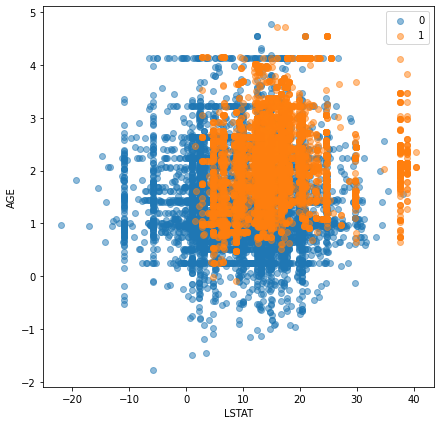

In [9]:
plot_diro2c_2d(explanation, 'LSTAT', 'AGE')

### Find Optimal Solution

In [10]:
%%time
metrics = search_max_depth_parameter(explanation, X, y_true=y_true)

CPU times: user 1min 43s, sys: 1.09 s, total: 1min 45s
Wall time: 1min 50s


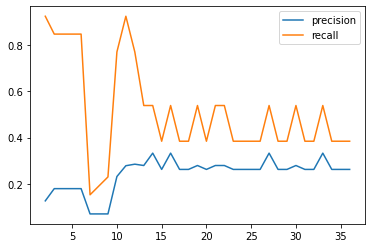

In [11]:
metrics.loc[:, ('precision', 'recall')].plot();

Unfortunately, no parameter setting explains all instances of the focus class (recall=1.0). But there are three settings with over 90% recall. The setting with max depth 2 will serve as the simpler (global) explanation, and the setting with max depth 11 as the more complete (local) explanation, because it has the highest precision.

In [12]:
metrics[metrics['recall'] > 0.9]

,precision,recall,rules,constraints
2,0.12766,0.923077,1,2
11,0.27907,0.923077,3,27


### Tree with depth 2

In [13]:
%%time
max_depth = 2
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 46.8 ms, sys: 2.98 ms, total: 49.8 ms
Wall time: 51.8 ms


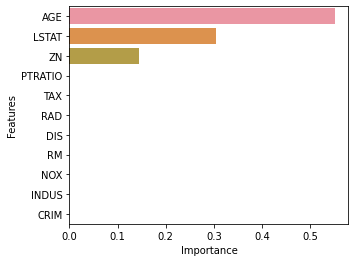

In [14]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 4))

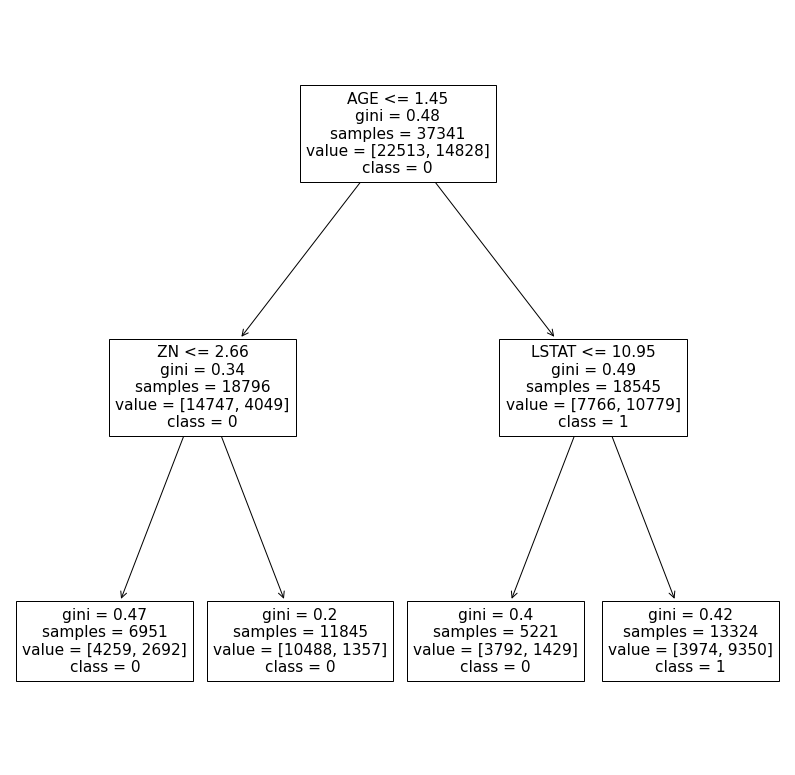

In [15]:
plot_surrogate_tree(explanation, precision=2)

In [16]:
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y_true)
print_rules(rules, class_occurences)

1. AGE > 1.45131516456604 and LSTAT > 10.949923992156982 [3974, 9350]


In [17]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.77      0.82      0.80     22513
           1       0.70      0.63      0.66     14828

    accuracy                           0.75     37341
   macro avg       0.74      0.73      0.73     37341
weighted avg       0.74      0.75      0.74     37341



#### Evaluation

##### Global Fidelity

In [18]:
global_fidelities[(max_depth, focus_class)] = evaluate(explanation, X, y_true)

              precision    recall  f1-score   support

           0       0.99      0.65      0.78       233
           1       0.13      0.92      0.22        13

    accuracy                           0.66       246
   macro avg       0.56      0.79      0.50       246
weighted avg       0.95      0.66      0.75       246



##### Counterfactual Fidelity Error

In [19]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule,
                                                      constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [20]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
CRIM,NaN,1.0,NaN
ZN,NaN,1.0,NaN
INDUS,NaN,1.0,NaN
NOX,NaN,NaN,NaN
RM,NaN,1.0,NaN
AGE,0.601862,0.0,0.0
DIS,NaN,1.0,NaN
RAD,NaN,1.0,NaN
TAX,NaN,1.0,NaN
PTRATIO,NaN,1.0,NaN


##### Complexity

In [21]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules          1
Constraints    2
dtype: int64

### Tree with depth 11

In [22]:
%%time
max_depth = 11
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 164 ms, sys: 6.85 ms, total: 171 ms
Wall time: 191 ms


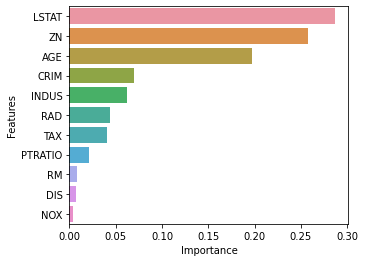

In [23]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 4))

In [24]:
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y_true)
len(rules)

170

In [25]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

8       0
28     43
40     43
42     57
74     43
151    43
152    43
157    43
180    43
196    43
238    24
244    43
245    57
dtype: int64

In [26]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. -19.442346572875977 < ZN <= 2.6632124185562134 and 7.963565111160278 < INDUS <= 22.765979766845703 and 0.799158900976181 < AGE <= 1.0506460070610046 and PTRATIO <= 20.121747970581055 and 9.638243675231934 < LSTAT <= 15.030436038970947 [33, 97]
2. CRIM <= 4.164170026779175 and -0.38191287219524384 < ZN <= 4.260478973388672 and INDUS > 7.939186096191406 and AGE > 1.45131516456604 and RAD <= 16.165803909301758 and TAX <= 590.5877075195312 and PTRATIO > 12.091929912567139 and 10.949923992156982 < LSTAT <= 18.012993812561035 [10, 25]
3. CRIM <= 2.538197159767151 and -0.38191287219524384 < ZN <= 5.940032243728638 and NOX > 0.5207433700561523 and AGE > 1.45131516456604 and TAX <= 590.5877075195312 and 18.012993812561035 < LSTAT <= 18.90103530883789 [5, 9]


In [27]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     22513
           1       0.89      0.97      0.93     14828

    accuracy                           0.94     37341
   macro avg       0.94      0.95      0.94     37341
weighted avg       0.95      0.94      0.94     37341



#### Evaluation

##### Global Fidelity

In [28]:
global_fidelities[(max_depth, focus_class)] = evaluate(explanation, X, y_true)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92       233
           1       0.27      0.92      0.41        13

    accuracy                           0.86       246
   macro avg       0.63      0.89      0.67       246
weighted avg       0.96      0.86      0.89       246



##### Counterfactual Fidelity Error

In [29]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule,
                                                      constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [30]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
CRIM,2.136865,0.352941,0.000000
ZN,2.264956,0.000000,0.500000
INDUS,5.240062,0.421053,0.000000
NOX,NaN,NaN,1.000000
RM,NaN,1.000000,NaN
AGE,0.631257,0.000000,0.076923
DIS,NaN,1.000000,NaN
RAD,6.142768,0.400000,0.000000
TAX,138.526888,0.500000,0.000000
PTRATIO,6.309417,0.500000,0.200000


##### Complexity

In [31]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules           3
Constraints    27
dtype: int64

## $(1, 2)$

In [32]:
focus_class = '(1, 2)'
focus_class_idx = list(comparer.class_names).index(focus_class)
y_true = mclass_diff == focus_class_idx

In [6]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 12min 2s, sys: 10.3 s, total: 12min 12s
Wall time: 14min 34s


In [33]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [34]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

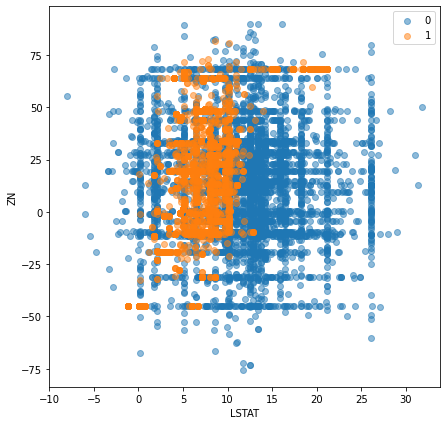

In [35]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### Find Optimal Solution

In [36]:
%%time
metrics = search_max_depth_parameter(explanation, X, y_true=y_true)

CPU times: user 19.9 s, sys: 174 ms, total: 20.1 s
Wall time: 20.5 s


Now all parameter settings achieve perfect recall. 10 and 11 are at a local high for precision, while not having too many constraints, as 15 does.

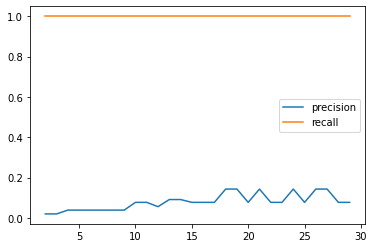

In [37]:
metrics.loc[:, ('precision', 'recall')].plot();

In [38]:
metrics[metrics['precision'] > 0.06]

,precision,recall,rules,constraints
10,0.076923,1.0,1,7
11,0.076923,1.0,1,7
13,0.090909,1.0,1,8
14,0.090909,1.0,1,9
15,0.076923,1.0,1,9
16,0.076923,1.0,1,9
17,0.076923,1.0,1,9
18,0.142857,1.0,1,10
19,0.142857,1.0,1,10
20,0.076923,1.0,1,9


### Tree with depth 10

In [39]:
%%time
max_depth = 10
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 97.4 ms, sys: 3.15 ms, total: 101 ms
Wall time: 115 ms


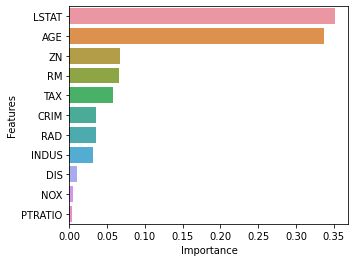

In [40]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 4))

In [41]:
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y_true)
len(rules)

85

In [42]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

51    2
dtype: int64

In [43]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. -3.3089312314987183 < CRIM <= 9.691678524017334 and -31.2040433883667 < ZN <= 45.05719757080078 and AGE <= 0.10356762632727623 and 2.102707028388977 < LSTAT <= 11.018762588500977 [8, 1588]


In [44]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     16933
           1       0.98      0.99      0.98      8013

    accuracy                           0.99     24946
   macro avg       0.99      0.99      0.99     24946
weighted avg       0.99      0.99      0.99     24946



#### Evaluation

##### Global Fidelity

In [45]:
global_fidelities[(max_depth, focus_class)] = evaluate(explanation, X, y_true)

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       245
           1       0.02      1.00      0.04         1

    accuracy                           0.83       246
   macro avg       0.51      0.91      0.47       246
weighted avg       1.00      0.83      0.90       246



##### Counterfactual Fidelity Error

In [46]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule,
                                                      constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [47]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
CRIM,4.308321,0.0,0.5
ZN,43.942802,0.0,0.5
INDUS,NaN,1.0,NaN
NOX,NaN,NaN,NaN
RM,NaN,1.0,NaN
AGE,0.103568,0.0,0.0
DIS,NaN,1.0,NaN
RAD,NaN,1.0,NaN
TAX,NaN,NaN,NaN
PTRATIO,NaN,1.0,NaN


##### Complexity

In [48]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules          1
Constraints    7
dtype: int64

## $(2, 1)$

In [49]:
focus_class = '(2, 1)'
focus_class_idx = list(comparer.class_names).index(focus_class)
y_true = mclass_diff == focus_class_idx

In [11]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 9min 35s, sys: 6.07 s, total: 9min 41s
Wall time: 10min 13s


In [50]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [51]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

### Find Optimal Solution

In [52]:
%%time
metrics = search_max_depth_parameter(explanation, X, y_true=y_true)

CPU times: user 1min 42s, sys: 1.07 s, total: 1min 43s
Wall time: 1min 48s


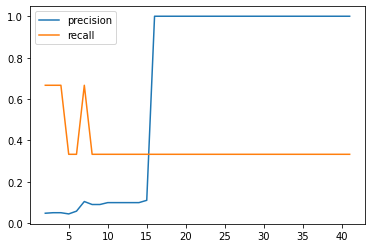

In [53]:
metrics.loc[:, ('precision', 'recall')].plot();

Unfortunately, no parameter setting covers all instances of the focus class. I'll select max depth 3, because it has the highest precision among those, that have the highest recall.

In [54]:
metrics[metrics['recall'] > 0.6]

,precision,recall,rules,constraints
2,0.048780,0.666667,1,2
3,0.051282,0.666667,1,3
4,0.051282,0.666667,1,4
7,0.105263,0.666667,2,14


### Tree with depth 3

In [55]:
%%time
max_depth = 3
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 74.4 ms, sys: 5.34 ms, total: 79.7 ms
Wall time: 312 ms


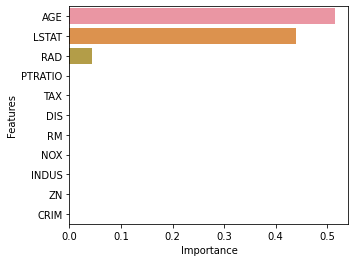

In [56]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 4))

In [57]:
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y_true)
len(rules)

2

In [58]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

34     1
77     0
101    1
dtype: int64

In [59]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. AGE > 1.5617687702178955 and 2.872923970222473 < LSTAT <= 12.960095405578613 [3684, 13023]


In [60]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.91      0.79      0.85     17980
           1       0.78      0.91      0.84     15085

    accuracy                           0.84     33065
   macro avg       0.85      0.85      0.84     33065
weighted avg       0.85      0.84      0.84     33065



#### Evaluation

##### Global Fidelity

In [61]:
global_fidelities[(max_depth, focus_class)] = evaluate(explanation, X, y_true)

              precision    recall  f1-score   support

           0       1.00      0.85      0.92       243
           1       0.05      0.67      0.10         3

    accuracy                           0.85       246
   macro avg       0.52      0.76      0.51       246
weighted avg       0.98      0.85      0.91       246



##### Counterfactual Fidelity Error

In [62]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule,
                                                      constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [63]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
CRIM,NaN,1.0,NaN
ZN,NaN,1.0,NaN
INDUS,NaN,1.0,NaN
NOX,NaN,NaN,NaN
RM,NaN,1.0,NaN
AGE,0.561769,0.0,0.0
DIS,NaN,1.0,NaN
RAD,NaN,1.0,NaN
TAX,NaN,1.0,NaN
PTRATIO,NaN,1.0,NaN


##### Complexity

In [64]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules          1
Constraints    3
dtype: int64

# Summary

In [70]:
def map_index(index):
    class_, depth = index[0], index[1]
    if class_ == '(0, 1)' and depth == 2:
        level = 'global'
    elif class_ == '(0, 1)' and depth == 11:
        level = 'local'
    elif class_ == '(1, 2)' and depth == 10:
        level = 'global'
    elif class_ == '(2, 1)' and depth == 3:
        level = 'global'
    else:
        level = None
    return (class_, level) if len(index) == 2 else (class_, level, index[2])

## Global Fidelity

In [71]:
global_fidelity = pd.concat(global_fidelities.values(), keys=global_fidelities.keys(), names=('depth', 'class'))
global_fidelity = global_fidelity[global_fidelity.index.get_level_values(2).astype(int) == 1]
global_fidelity.index = global_fidelity.index.droplevel(2)
global_fidelity = global_fidelity.reorder_levels(['class', 'depth']).sort_index()
global_fidelity

Precision    Recall  F1 Score  Support
class  depth                                        
(0, 1) 2       0.127660  0.923077  0.224299       13
       11      0.266667  0.923077  0.413793       13
(1, 2) 10      0.022727  1.000000  0.044444        1
(2, 1) 3       0.051282  0.666667  0.095238        3

## Local Fidelity

In [72]:
local_fidelity = pd.concat(local_fidelities.values(), keys=local_fidelities.keys(), names=('depth', 'class', 'feature'))
local_fidelity = local_fidelity.reorder_levels(['class', 'depth', 'feature']).sort_index()
local_fidelity

RMSE       BMR       BAR
class  depth feature                                
(0, 1) 2     AGE        0.601862  0.000000  0.000000
             CRIM            NaN  1.000000       NaN
             DIS             NaN  1.000000       NaN
             INDUS           NaN  1.000000       NaN
             LSTAT      4.180346  0.500000  0.000000
             NOX             NaN       NaN       NaN
             PTRATIO         NaN  1.000000       NaN
             RAD             NaN  1.000000       NaN
             RM              NaN  1.000000       NaN
             TAX             NaN  1.000000       NaN
             ZN              NaN  1.000000       NaN
       11    AGE        0.631257  0.000000  0.076923
             CRIM       2.136865  0.352941  0.000000
             DIS             NaN  1.000000       NaN
             INDUS      5.240062  0.421053  0.000000
             LSTAT      3.134327  0.000000  0.000000
             NOX             NaN       NaN  1.000000
             PTRATIO    6.309417  0.500000  0.200000
             RAD        6.142768  0.400000  0.000000
             RM              NaN  1.000000       NaN
             TAX      138.526888  0.500000  0.000000
             ZN         2.264956  0.000000  0.500000
(1, 2) 10    AGE        0.103568  0.000000  0.000000
             CRIM       4.308321  0.000000  0.500000
             DIS             NaN  1.000000       NaN
             INDUS           NaN  1.000000       NaN
             LSTAT      3.764692  0.000000  0.000000
             NOX             NaN       NaN       NaN
             PTRATIO         NaN  1.000000       NaN
             RAD             NaN  1.000000       NaN
             RM              NaN  1.000000       NaN
             TAX             NaN       NaN       NaN
             ZN        43.942802  0.000000  0.500000
(2, 1) 3     AGE        0.561769  0.000000  0.000000
             CRIM            NaN  1.000000       NaN
             DIS             NaN  1.000000       NaN
             INDUS           NaN  1.000000       NaN
             LSTAT      4.562230  0.000000  0.000000
             NOX             NaN       NaN       NaN
             PTRATIO         NaN  1.000000       NaN
             RAD             NaN  1.000000       NaN
             RM              NaN  1.000000       NaN
             TAX             NaN  1.000000       NaN
             ZN              NaN  1.000000       NaN

## Complexity

In [73]:
complexity = pd.concat(complexities.values(), axis=1, keys=complexities.keys(), names=('depth', 'class')).T
complexity = complexity.reorder_levels(['class', 'depth']).sort_index()
complexity

Rules  Constraints
class  depth                    
(0, 1) 2          1            2
       11         3           27
(1, 2) 10         1            7
(2, 1) 3          1            3

## Generation Time

approx. 47m

In [74]:
global_fidelity.index = global_fidelity.index.map(map_index)
global_fidelity = global_fidelity[global_fidelity.index.get_level_values('depth').notnull()]
global_fidelity.index.rename(['class', 'level'], inplace=True)

local_fidelity.index = local_fidelity.index.map(map_index)
local_fidelity = local_fidelity[local_fidelity.index.get_level_values('depth').notnull()]
local_fidelity.index.rename(['class', 'level', 'feature'], inplace=True)

complexity.index = complexity.index.map(map_index)
complexity = complexity[complexity.index.get_level_values('depth').notnull()]
complexity.index.rename(['class', 'level'], inplace=True)

with open('results.soa.pickle', 'wb') as f:
    pickle.dump((global_fidelity, local_fidelity, complexity), f)